# Automation for Small TechBio Teams  
From One-Off Notebooks to Simple Pipelines

In the earlier notebooks, you ran the TechBio loop step by step:

1. Load or simulate data  
2. Clean it  
3. Train a model  
4. Make predictions  
5. Look at results  

This works for one experiment, but it breaks down when you have:

- 10 experiments  
- 50 datasets  
- weekly re-runs  

This notebook shows how to turn that workflow into a **small automated pipeline** that a small TechBio team can actually use.

We will:

1. Wrap the work into **functions**  
2. Apply those functions to **multiple datasets** in a loop  
3. **Save artifacts** (cleaned data, models, and metrics) for later use

No cloud platforms. No huge orchestration systems.  
Just clean Python code that respects your time.


In [1]:
# 0. Imports and basic setup

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from joblib import dump  # for saving models

plt.style.use("seaborn-v0_8-whitegrid")
np.random.seed(42)

# Create an output folder
os.makedirs("automation_outputs", exist_ok=True)


---

## 1. A Tiny TechBio Workflow

We’ll automate a minimal version of the loop:

> raw data → cleaned data → trained model → predictions → metrics

To keep things simple, we simulate **several experiments**.  
Each experiment is a fake dataset of candidates with:

- two features (`Feature_1`, `Feature_2`)  
- a noisy measured response (`Measured_Response`)  

We pretend these come from different assay runs or different days in the lab.


In [2]:
# 1.1 Function to simulate a single raw dataset

def simulate_raw_dataset(experiment_id: int, n_candidates: int = 80) -> pd.DataFrame:
    """
    Simulate a raw dataset for one experiment.
    Each candidate has two features and a noisy response.
    """
    candidate_ids = [f"EXP{experiment_id}_CAND_{i:03d}" for i in range(1, n_candidates + 1)]
    
    feature_1 = np.random.uniform(0, 1, size=n_candidates)
    feature_2 = np.random.uniform(0, 1, size=n_candidates)
    
    # hidden signal + noise
    true_signal = 0.6 * feature_1 + 0.3 * feature_2
    measured_response = true_signal + np.random.normal(0, 0.1, size=n_candidates)
    
    raw_df = pd.DataFrame({
        "Candidate_ID": candidate_ids,
        "Feature_1": feature_1,
        "Feature_2": feature_2,
        "Measured_Response": measured_response
    }).set_index("Candidate_ID")
    
    # introduce some missing values to keep life interesting
    mask = np.random.rand(n_candidates) < 0.1
    raw_df.loc[mask, "Measured_Response"] = np.nan
    
    return raw_df

# quick preview
simulate_raw_dataset(experiment_id=1).head()


,Feature_1,Feature_2,Measured_Response
Candidate_ID,,,
EXP1_CAND_001,0.374540,0.863103,0.623935
EXP1_CAND_002,0.950714,0.623298,0.617233
EXP1_CAND_003,0.731994,0.330898,0.597151
EXP1_CAND_004,0.598658,0.063558,0.597308
EXP1_CAND_005,0.156019,0.310982,0.087852


---
## 2. Turning Steps into Functions

Instead of writing the same code 10 times, we turn each step into a function:

- `clean_data(df)` – fixes missing values and standardizes columns  
- `train_model(clean_df)` – trains a model on one experiment  
- `run_inference(model, clean_df)` – predicts responses  
- `compute_metrics(clean_df, preds)` – gives us simple quality numbers  

Once we have these, we can reuse them for every experiment.


In [3]:
# 2.1 Cleaning function

def clean_data(raw_df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean a raw dataset:
    - drop rows with all-null features
    - impute missing Measured_Response with the column mean
    """
    df = raw_df.copy()
    
    # drop completely empty rows (very rare here but good habit)
    df = df.dropna(how="all")
    
    # impute missing responses
    if df["Measured_Response"].isnull().any():
        mean_value = df["Measured_Response"].mean()
        df["Measured_Response"] = df["Measured_Response"].fillna(mean_value)
    
    return df

# 2.2 Model training function

def train_model(clean_df: pd.DataFrame) -> RandomForestRegressor:
    """
    Train a simple RandomForestRegressor on one cleaned dataset.
    """
    features = ["Feature_1", "Feature_2"]
    X = clean_df[features]
    y = clean_df["Measured_Response"]
    
    model = RandomForestRegressor(
        n_estimators=100,
        random_state=42
    )
    model.fit(X, y)
    return model

# 2.3 Inference function

def run_inference(model: RandomForestRegressor, clean_df: pd.DataFrame) -> np.ndarray:
    """
    Run predictions on the given cleaned dataset.
    """
    features = ["Feature_1", "Feature_2"]
    X = clean_df[features]
    preds = model.predict(X)
    return preds

# 2.4 Metric computation

def compute_metrics(clean_df: pd.DataFrame, preds: np.ndarray) -> dict:
    """
    Compute a simple RMSE between predicted and measured response.
    """
    y_true = clean_df["Measured_Response"].values
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    return {"rmse": rmse}


---
## 3. Running the Workflow for One Experiment

Before we batch anything, we verify that the pipeline works for a **single** experiment.

We will:

1. simulate raw data  
2. clean it  
3. train a model  
4. make predictions  
5. compute RMSE  
6. save the artifacts


In [4]:
# 3.1 Run the full workflow for a single experiment

def run_full_workflow_for_experiment(experiment_id: int) -> dict:
    """
    Runs the complete pipeline for one experiment:
    - simulate raw data
    - clean
    - train
    - predict
    - compute metrics
    - save artifacts
    Returns a dictionary with metrics.
    """
    # 1. simulate raw data
    raw_df = simulate_raw_dataset(experiment_id)
    
    # 2. clean
    clean_df = clean_data(raw_df)
    
    # 3. train model
    model = train_model(clean_df)
    
    # 4. inference
    preds = run_inference(model, clean_df)
    
    # 5. metrics
    metrics = compute_metrics(clean_df, preds)
    
    # 6. save artifacts
    prefix = f"automation_outputs/exp_{experiment_id}"
    
    raw_df.to_csv(f"{prefix}_raw.csv")
    clean_df.to_csv(f"{prefix}_clean.csv")
    dump(model, f"{prefix}_model.joblib")
    
    # save predictions and metrics
    results_df = clean_df.copy()
    results_df["Predicted_Response"] = preds
    results_df.to_csv(f"{prefix}_results.csv")
    
    metrics["experiment_id"] = experiment_id
    return metrics

# Test on one experiment
single_metrics = run_full_workflow_for_experiment(1)
single_metrics


{'rmse': np.float64(0.047511215464565895), 'experiment_id': 1}

---
## 4. Batching: Running the Pipeline for Many Experiments

Now we do the thing that actually matters:

> Instead of manually copying cells for each dataset,  
> we call the same function in a loop.

We’ll simulate multiple experiments (`EXP1`, `EXP2`, `EXP3`, …),  
run the full workflow on each,  
and collect the metrics in a single table.


In [5]:
# 4.1 Run the workflow on many experiments

experiment_ids = [1, 2, 3, 4, 5]

all_metrics = []

for exp_id in experiment_ids:
    metrics = run_full_workflow_for_experiment(exp_id)
    all_metrics.append(metrics)

metrics_df = pd.DataFrame(all_metrics).set_index("experiment_id")
metrics_df


,rmse
experiment_id,
1,0.046012
2,0.046911
3,0.044298
4,0.055727
5,0.053558


---
### 4.2 Visualizing metrics across experiments

A small plot helps us see how stable or noisy the experiments are.

This is the kind of simple monitoring plot that a small TechBio team can keep  
in place of a huge dashboard.


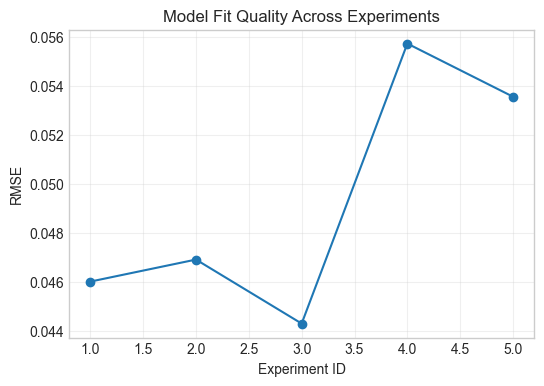

In [6]:
plt.figure(figsize=(6,4))
plt.plot(metrics_df.index, metrics_df["rmse"], marker="o")
plt.xlabel("Experiment ID")
plt.ylabel("RMSE")
plt.title("Model Fit Quality Across Experiments")
plt.grid(True, alpha=0.3)
plt.show()


---

## 5. What We Saved (Artifacts)

For each experiment, the pipeline wrote files into the `automation_outputs` folder:

- `exp_X_raw.csv` – the raw simulated data  
- `exp_X_clean.csv` – the cleaned dataset  
- `exp_X_model.joblib` – the trained model  
- `exp_X_results.csv` – data + predictions  

Plus, `metrics_df` holds a compact summary across all experiments.

This is the beginning of **reproducibility and auditability**:
you can rerun, inspect, or share results without rerunning everything by hand.


In [7]:
# Quick peek at saved files
os.listdir("automation_outputs")[:10]


['exp_1_clean.csv',
 'exp_1_model.joblib',
 'exp_1_raw.csv',
 'exp_1_results.csv',
 'exp_2_clean.csv',
 'exp_2_model.joblib',
 'exp_2_raw.csv',
 'exp_2_results.csv',
 'exp_3_clean.csv',
 'exp_3_model.joblib']

---
## 6. Your Turn: Make the Automation More Real

To really understand how this helps a TechBio team, try changing a few things.

### 1. Change the number of experiments

Modify:

```python
experiment_ids = [1, 2, 3, 4, 5]
to something like code below and watch how the metrics table and RMSE plot grow:

In [8]:
experiment_ids = range(1, 11)


### 2. Make one experiment noisier

Inside `simulate_raw_dataset`, add a conditional:

In [9]:
if experiment_id == 3:
    measured_response = true_signal + np.random.normal(0, 0.25, size=n_candidates)


NameError: name 'experiment_id' is not defined

### 3. Save a global metrics file

After building `metrics_df`, save it.
This is the kind of simple artifact that can be shared with collaborators
without sending all the raw data:

In [10]:
metrics_df.to_csv("automation_outputs/all_experiments_metrics.csv")


### 4. Swap the model

Replace `RandomForestRegressor` with another regressor,
or change its hyperparameters, and rerun the whole pipeline.
Because the workflow is now automated, testing changes becomes cheap.

### 7. Final Takeaway

Automation does not start with giant cloud systems.
It starts with:

wrapping your steps into functions

running those functions over batches of data

saving what you produce so others (or future you) can reuse it

For a small TechBio team, this kind of lightweight automation:

* removes copy-paste work
* reduces mistakes
* makes re-runs easy
* and prepares the ground for larger platforms later

Once your notebook looks like this,
you are no longer just running analyses.
You are running the first version of a **TechBio** pipeline.